0:	learn: 0.5381179	total: 30.8ms	remaining: 15.4s
100:	learn: 0.0027344	total: 586ms	remaining: 2.31s
200:	learn: 0.0011961	total: 878ms	remaining: 1.3s
300:	learn: 0.0007956	total: 1.16s	remaining: 767ms
400:	learn: 0.0007954	total: 1.42s	remaining: 350ms
499:	learn: 0.0007951	total: 1.66s	remaining: 0us
🔹 Accuracy: 0.9990925589836661
🔹 Precision: 1.0
🔹 Recall: 0.9896373056994818
🔹 F1 Score: 0.9947916666666666
🔹 Cohen’s Kappa Score: 0.9942946635430554

🔹 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2011
         1.0       1.00      0.99      0.99       193

    accuracy                           1.00      2204
   macro avg       1.00      0.99      1.00      2204
weighted avg       1.00      1.00      1.00      2204



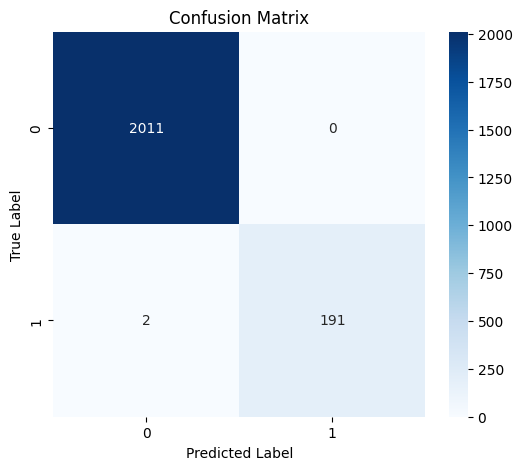

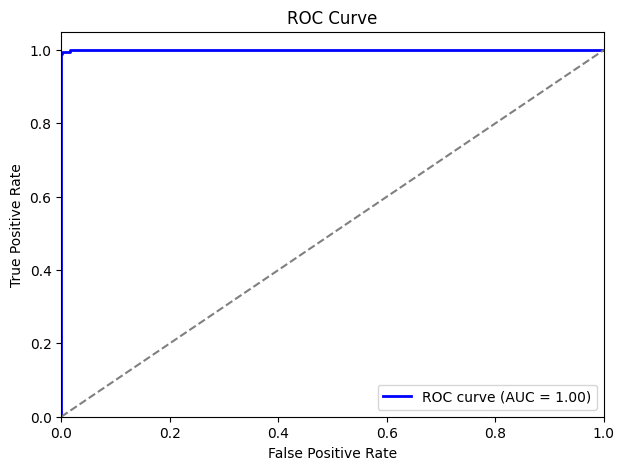

In [ ]:
# Catboost Algorithm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, cohen_kappa_score

# Step 1: Load Dataset
df = pd.read_excel("/content/PS 2_Dataset_trash data.xlsx", engine='openpyxl')

# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Step 2: Fix Date and Time issues
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
df['TIME'] = df['TIME'].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})', expand=False)
df['TIME'] = df['TIME'].fillna('00:00:00')

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['TIME'], errors='coerce')

# Step 3: Feature Engineering
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek + 1
df['is_weekend'] = (df['day_of_week'] >= 6).astype(int)

df['prev_fill_status'] = df.groupby('BIN ID', observed=False)['FILL PERCENTAGE'].shift(1).fillna(0)
df['fill_rate'] = df.groupby('BIN ID', observed=False)['FILL LEVEL(IN LITRES)'].diff().fillna(0)

# Step 4: Convert Categorical Features
df['LOCATION'] = df['LOCATION'].astype('category')
df['BIN ID'] = df['BIN ID'].astype('category')

# Fix LATITUDE and LONGITUDE: Convert to Numeric
df['LATITUDE'] = df['LATITUDE'].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)
df['LONGITUDE'] = df['LONGITUDE'].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)

# Step 5: Define Features and Target
features = ['hour', 'day_of_week', 'is_weekend', 'prev_fill_status', 'fill_rate',
            'LATITUDE', 'LONGITUDE', 'TEMPERATURE( IN ⁰C)', 'BATTERY LEVEL']
target = 'FILL LEVEL INDICATOR(Above 550)'

# Convert TEMPERATURE( IN ⁰C) to a proper float (removing special characters)
df['TEMPERATURE( IN ⁰C)'] = df['TEMPERATURE( IN ⁰C)'].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)


# Drop NaN target values
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

# Step 6: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train CatBoost Model
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)
catboost_model.fit(X_train, y_train)

# Step 8: Model Evaluation
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]  # Get probability scores for ROC-AUC

# 🔹 Print Evaluation Metrics
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("🔹 Precision:", precision_score(y_test, y_pred))
print("🔹 Recall:", recall_score(y_test, y_pred))
print("🔹 F1 Score:", f1_score(y_test, y_pred))
print("🔹 Cohen’s Kappa Score:", cohen_kappa_score(y_test, y_pred))  # New Metric
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 10: ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


Data shape after dropping NaNs: (11019, 13)
Data shape after sampling 10%: (1102, 13)

After SMOTE, training set class distribution:
FILL LEVEL INDICATOR(Above 550)
0    806
1    806
Name: count, dtype: int64

=== KNeighborsClassifier Metrics ===
Accuracy : 0.8824
Precision: 0.1111
Recall   : 0.0526
F1-score : 0.0714
Confusion Matrix:
[[194   8]
 [ 18   1]]


<ipython-input-15-20b0f0958061>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, 'TEMPERATURE( IN ⁰C)'] = data['TEMPERATURE( IN ⁰C)'].replace(r'[^0-9\.]+', '', regex=True).astype(float)


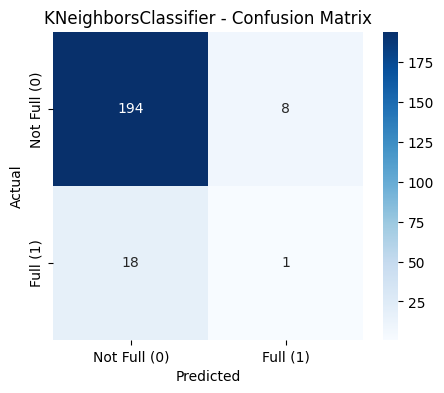

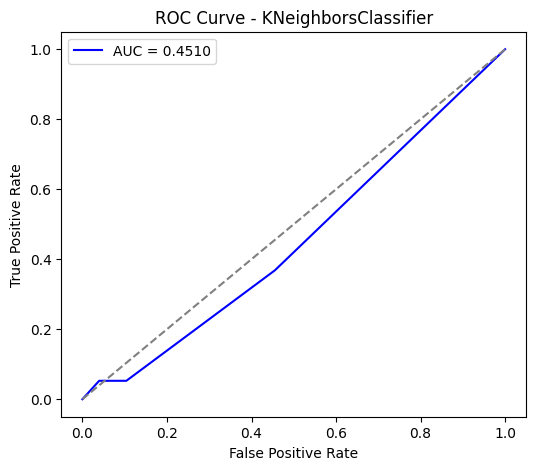

ROC AUC Score: 0.4510
Cohen’s Kappa Score: 0.0171

Total running time: 4.67 seconds


In [ ]:
# K Neighbor Classifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
import time

start_time = time.time()

# 1. Load the dataset
file_path = 'AI Trash Data.xlsx'
data = pd.read_excel(file_path)

# 2. Clean column names and drop NaNs
data.columns = data.columns.str.strip()
data = data.dropna().copy()
print("Data shape after dropping NaNs:", data.shape)

# Optionally sample to speed up training
data = data.sample(frac=0.1, random_state=42).copy()
print("Data shape after sampling 10%:", data.shape)

# 3. Clean numeric columns
data.loc[:, 'TEMPERATURE( IN ⁰C)'] = data['TEMPERATURE( IN ⁰C)'].replace(r'[^0-9\.]+', '', regex=True).astype(float)
data.loc[:, 'BATTERY LEVEL'] = pd.to_numeric(data['BATTERY LEVEL'], errors='coerce')
data.loc[:, 'LATITUDE'] = data['LATITUDE'].replace(r'[^\d\.]+', '', regex=True).astype(float)
data.loc[:, 'LONGITUDE'] = data['LONGITUDE'].replace(r'[^\d\.]+', '', regex=True).astype(float)

# 4. Define target and features
target_col = 'FILL LEVEL INDICATOR(Above 550)'
y = data[target_col].astype(int)

feature_cols = ['WEEK NO', 'TOTAL(LITRES)', 'LATITUDE', 'LONGITUDE']
X = data[feature_cols].copy()
if 'LOCATION' in data.columns:
  # If LOCATION is present, converts categorical values to numerical using one-hot encoding (get_dummies).
    X = pd.concat([X, pd.get_dummies(data['LOCATION'], prefix='loc')], axis=1)

# 5. Split, scale, and apply SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE, training set class distribution:")
print(pd.Series(y_train_res).value_counts())

# 6. Train KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)

# 7. Evaluate the model
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\n=== KNeighborsClassifier Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# 8. Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Full (0)', 'Full (1)'],
            yticklabels=['Not Full (0)', 'Full (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNeighborsClassifier - Confusion Matrix")
plt.show()

# 9. Plot ROC Curve & Compute AUC Score
y_scores = knn.predict_proba(X_test_scaled)[:, 1]  # Probability scores for the positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNeighborsClassifier')
plt.legend()
plt.show()

print(f"ROC AUC Score: {auc_score:.4f}")

# 10. Compute Cohen’s Kappa Score
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen’s Kappa Score: {kappa:.4f}")

end_time = time.time()
print("\nTotal running time: {:.2f} seconds".format(end_time - start_time))


Data shape after dropping NaNs: (11019, 13)
Data shape after sampling 10%: (1102, 13)

After SMOTE, training set class distribution:
FILL LEVEL INDICATOR(Above 550)
0    806
1    806
Name: count, dtype: int64

=== DecisionTreeClassifier Metrics ===
Accuracy : 0.6335
Precision: 0.0921
Recall   : 0.3684
F1-score : 0.1474
Confusion Matrix:
[[133  69]
 [ 12   7]]

=== Additional Metrics ===
Cohen's Kappa Score: 0.0114
AUC Score: 0.5263


<ipython-input-16-928b309a7009>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, 'TEMPERATURE( IN ⁰C)'] = data['TEMPERATURE( IN ⁰C)'].replace(r'[^0-9\.]+', '', regex=True).astype(float)


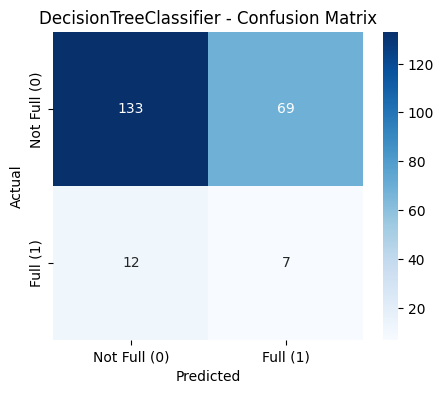

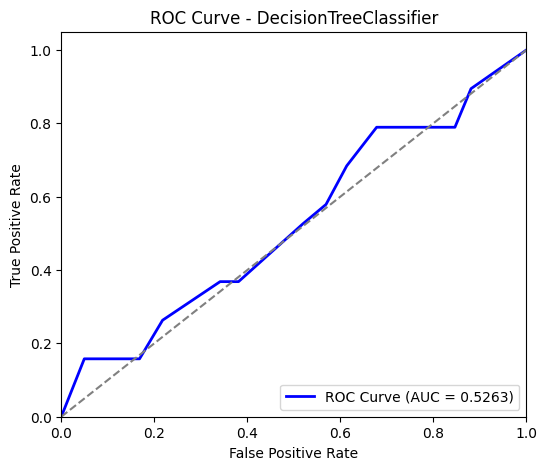


Total running time: 4.35 seconds


In [ ]:
# Decision Tree Classifier
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
import time

start_time = time.time()

# 1. Load the dataset
file_path = 'AI Trash Data.xlsx'  # Fixed file path
data = pd.read_excel(file_path)

# 2. Clean column names and drop NaNs
data.columns = data.columns.str.strip()
data = data.dropna().copy()
print("Data shape after dropping NaNs:", data.shape)

# Optionally sample to speed up training
data = data.sample(frac=0.1, random_state=42).copy()
print("Data shape after sampling 10%:", data.shape)

# 3. Clean numeric columns
data.loc[:, 'TEMPERATURE( IN ⁰C)'] = data['TEMPERATURE( IN ⁰C)'].replace(r'[^0-9\.]+', '', regex=True).astype(float)
data.loc[:, 'BATTERY LEVEL'] = pd.to_numeric(data['BATTERY LEVEL'], errors='coerce')
data.loc[:, 'LATITUDE'] = data['LATITUDE'].replace(r'[^\d\.]+', '', regex=True).astype(float)
data.loc[:, 'LONGITUDE'] = data['LONGITUDE'].replace(r'[^\d\.]+', '', regex=True).astype(float)

# 4. Define target and features
target_col = 'FILL LEVEL INDICATOR(Above 550)'
y = data[target_col].astype(int)

feature_cols = ['WEEK NO', 'TOTAL(LITRES)', 'LATITUDE', 'LONGITUDE']
X = data[feature_cols].copy()
if 'LOCATION' in data.columns:
    X = pd.concat([X, pd.get_dummies(data['LOCATION'], prefix='loc')], axis=1)

# 5. Split, scale, and apply SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE, training set class distribution:")
print(pd.Series(y_train_res).value_counts())

# 6. Train DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train_res, y_train_res)

# 7. Evaluate the model
y_pred = dt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\n=== DecisionTreeClassifier Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# Compute Additional Metrics
cohen_kappa = cohen_kappa_score(y_test, y_pred)
y_pred_prob = dt.predict_proba(X_test_scaled)[:, 1]  # Get probability scores for class 1
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("\n=== Additional Metrics ===")
print(f"Cohen's Kappa Score: {cohen_kappa:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Full (0)', 'Full (1)'],
            yticklabels=['Not Full (0)', 'Full (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DecisionTreeClassifier - Confusion Matrix")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()

end_time = time.time()
print("\nTotal running time: {:.2f} seconds".format(end_time - start_time))
